0    284315
1       492
Name: Class, dtype: int64


Text(0,0.5,'Frequency')

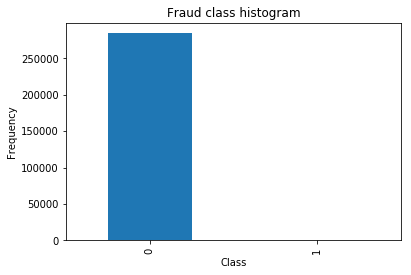

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = pd.read_csv("creditcard.csv")
data.head()
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
print(count_classes)
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [2]:
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [3]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)
normal_indices = data[data.Class == 0].index
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = data.iloc[under_sample_indices,:]

In [4]:
X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']
print("正常数据占比: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("异常数据占比: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("样本总量为: ", len(under_sample_data))

正常数据占比:  0.5
异常数据占比:  0.5
样本总量为:  984


In [5]:
from sklearn.model_selection import train_test_split
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("训练集样本数量: ", len(X_train_undersample))
print("测试集样本数量: ", len(X_test_undersample))
print("样本数量: ", len(X_train_undersample)+len(X_test_undersample))


训练集样本数量:  688
测试集样本数量:  296
样本数量:  984


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix,recall_score,classification_report
def crossLogistic(x_train_data,y_train_data):
    c_param_range = [0.001,0.01,0.1,1,10,100]
    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','平均召回率'])
    results_table['C_parameter'] = c_param_range
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C 参数: ', c_param)
        print('-------------------------------------------')
        print('')
        lr = LogisticRegression(C = c_param, penalty = 'l2')
        scores = cross_val_score(lr, x_train_data, y_train_data, cv=5)    
        print(f"各次迭代的决定系数：{scores}")
        print(f"平均决定系数：{scores.mean()}")  
        row = np.where(np.array(c_param_range) == c_param)
        results_table.loc[row[0],'平均召回率'] = scores.mean()
    best_c = results_table.loc[results_table['平均召回率'].astype(float).idxmax()]['C_parameter']   
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    return best_c

In [7]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

-------------------------------------------
C 参数:  0.001
-------------------------------------------

各次迭代的决定系数：[0.9057971  0.89130435 0.9057971  0.93430657 0.9270073 ]
平均决定系数：0.9128424838675553
-------------------------------------------
C 参数:  0.01
-------------------------------------------

各次迭代的决定系数：[0.91304348 0.91304348 0.94202899 0.96350365 0.9270073 ]

C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when 


平均决定系数：0.9317253781868191
-------------------------------------------
C 参数:  0.1
-------------------------------------------

各次迭代的决定系数：[0.91304348 0.91304348 0.95652174 0.95620438 0.93430657]
平均决定系数：0.9346239289114566
-------------------------------------------
C 参数:  1
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when 

各次迭代的决定系数：[0.91304348 0.92028986 0.94927536 0.94890511 0.9270073 ]
平均决定系数：0.9317042208822596
-------------------------------------------
C 参数:  10
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


各次迭代的决定系数：[0.9057971  0.91304348 0.94202899 0.94890511 0.93430657]
平均决定系数：0.9288162488099017
-------------------------------------------
C 参数:  100
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

各次迭代的决定系数：[0.91304348 0.91304348 0.94202899 0.95620438 0.94160584]
平均决定系数：0.9331852322014175
*********************************************************************************
Best model to choose from cross validation is with C parameter =  0.1
*********************************************************************************
Recall metric in the testing dataset:  0.9115646258503401


C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted wi

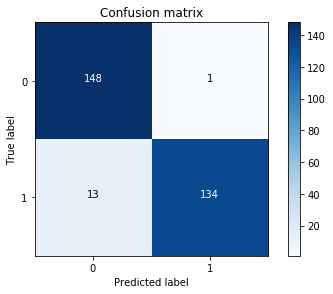

In [8]:
best_c = crossLogistic(X_train_undersample,y_train_undersample)
import itertools
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Recall metric in the testing dataset:  0.9047619047619048


C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


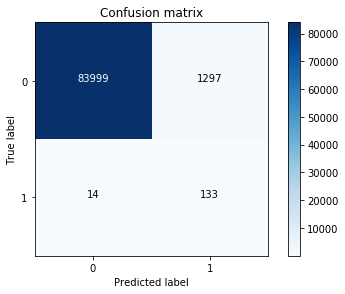

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [10]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
credit_cards=pd.read_csv('creditcard.csv')
columns=credit_cards.columns
features_columns=columns.delete(len(columns)-1)
features=credit_cards[features_columns]
labels=credit_cards['Class']
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=0)
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_resample(features_train,labels_train)
len(os_labels[os_labels==1])

227454

-------------------------------------------
C 参数:  0.001
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when 

各次迭代的决定系数：[0.97 0.97 0.97 0.97 0.97]
平均决定系数：0.9702555240335746
-------------------------------------------
C 参数:  0.01
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

各次迭代的决定系数：[0.97 0.97 0.97 0.97 0.97]
平均决定系数：0.9711018467336217
-------------------------------------------
C 参数:  0.1
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was ex

各次迭代的决定系数：[0.97 0.97 0.97 0.97 0.97]
平均决定系数：0.9714623621945877
-------------------------------------------
C 参数:  1
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

各次迭代的决定系数：[0.96 0.97 0.97 0.97 0.97]
平均决定系数：0.968343063896004
-------------------------------------------
C 参数:  10
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (statu

各次迭代的决定系数：[0.97 0.97 0.97 0.97 0.97]
平均决定系数：0.9716404196584912
-------------------------------------------
C 参数:  100
-------------------------------------------



C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

各次迭代的决定系数：[0.97 0.97 0.97 0.97 0.97]
平均决定系数：0.9718382611105512
*********************************************************************************
Best model to choose from cross validation is with C parameter =  100.0
*********************************************************************************
Recall metric in the testing dataset:  0.8910891089108911


C:\Users\33131\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


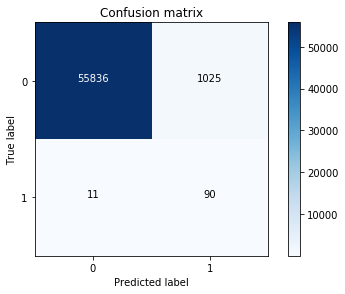

In [11]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)
best_c = crossLogistic(os_features,os_labels)
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(os_features,os_labels.values.ravel())
y_pred = lr.predict(features_test.values)
cnf_matrix = confusion_matrix(labels_test,y_pred)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()